<h1><center>Concrete Strength Prediction</center></h1>
<h4><i><center>Data Analysis and Modeling by: Varun Kulkarni (kulkarnivarun@outlook.com) </center></i></h4>

## Objective
To predict the concrete strength using the data available in file concrete.csv. Apply feature engineering and model tuning to obtain 80% to 95% of R2score.


## Data Source
concrete.csv (https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/.)

## Tasks
- [Exploratory Data Analysis](#1)
    - [Univariate Analysis](#1.1)
    - [Multivariate Analysis](#1.2)
    - [Feature Engineering](#1.3)
- [Model Creation and Tuning](#2)
    - [Creating And Evaluating Models](#2.1)
    - [Hyperparameter Tuning](#2.2)
- [Conclusion](#3)   

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from time import time
import warnings
from math import sqrt
from os import system
from scipy.stats import randint as sp_randint

# Import rtelevant utilities from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Import relevant models from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Import validation and hpyer parameter search utilities
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
 
# Environment and global settings
%matplotlib inline
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
SEED=42 # seed for random state for splitting data and models.
NUM_FOLDS=10 # splits for K-fold cross validation

## Exploratory Data Analysis <a class="anchor" id='1'></a>
In this section we will look at characteristics and distributions of given variables. Explore co-relations between various independent variables and how they impact the target variable.

In [2]:
# Import dataset and get familiar with the data
data_df = pd.read_csv('concrete.csv')
data_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


### Univariate Analysis <a class="anchor" id='1.1'></a>

In [3]:
# Shape of the dataset
print("There are {0} records and {1} variables.".format(data_df.shape[0], data_df.shape[1]))

# Check for null values
if data_df.isnull().values.any():
    print("Null values found!")
else:
    print("No null values found.")
    
# Check for NA values
if data_df.isna().values.any():
    print("NA values found!")
else:
    print("No NA values found.")
    
# Check for duplicated values
print("Number of duplicated records: ", data_df.duplicated().sum())

There are 1030 records and 9 variables.
No null values found.
No NA values found.
Number of duplicated records:  25


In [4]:
# Let's look at the data types and other related details
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
# Let's look at how many zero values are reported per attribute
pd.DataFrame((data_df == 0.0).sum(axis=0), columns=['Number of zero values']).T

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
Number of zero values,0,471,566,0,379,0,0,0,0


In [6]:
# Let's look at the five point summary
data_df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


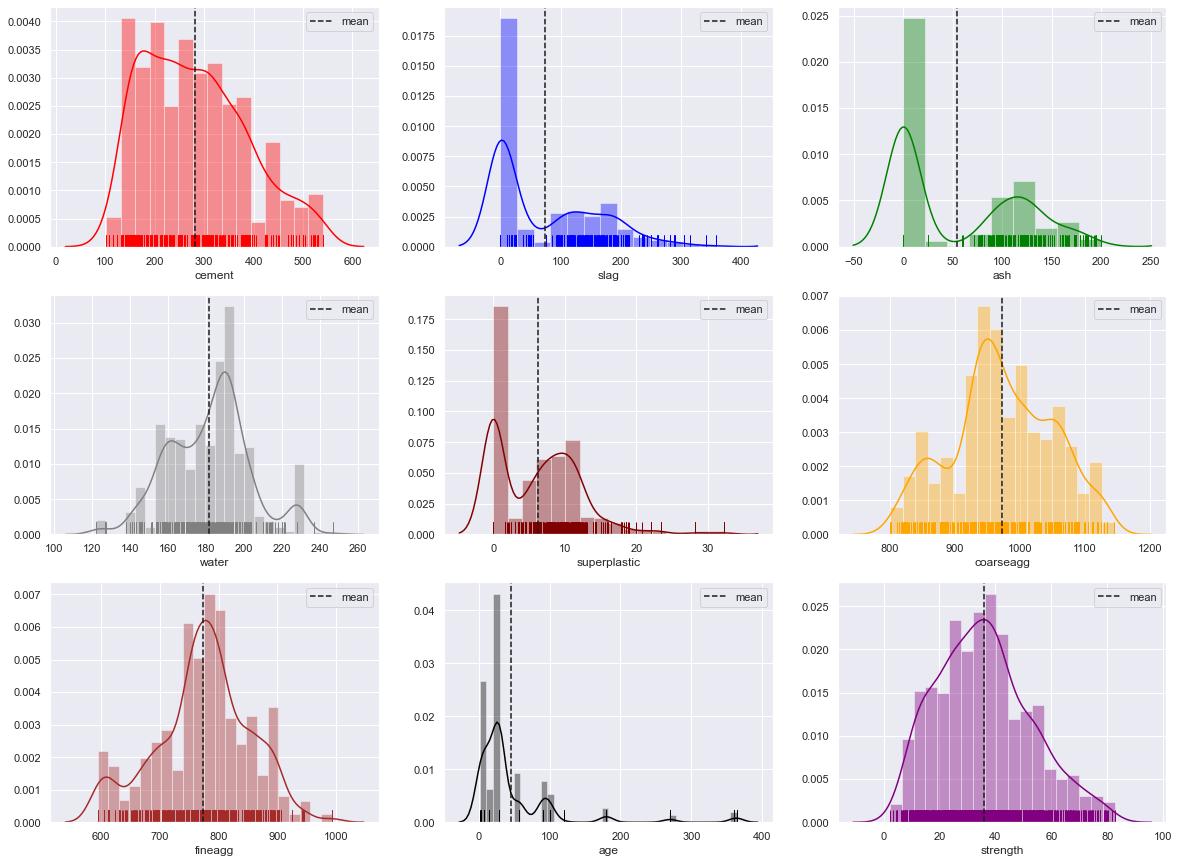

In [7]:
# All attribute values appear to be numeric and continuous. 
# Let's look at the distributions of these attibutes individually.

# Colors for plots
plot_colors = ['red', 'blue', 'green', 'grey', 'maroon', 'orange', 'brown', 'black', 'purple']

# Plot univariate distributions
plt.figure(figsize=(20,15))
for idx, col in enumerate(data_df.columns):
    plt.subplot(3, 3, idx+1)
    sns.distplot(data_df[col], color=plot_colors[idx], rug=True)
    plt.axvline(data_df[col].mean(), linestyle="dashed", label="mean", color="k")
    plt.legend(loc="best")

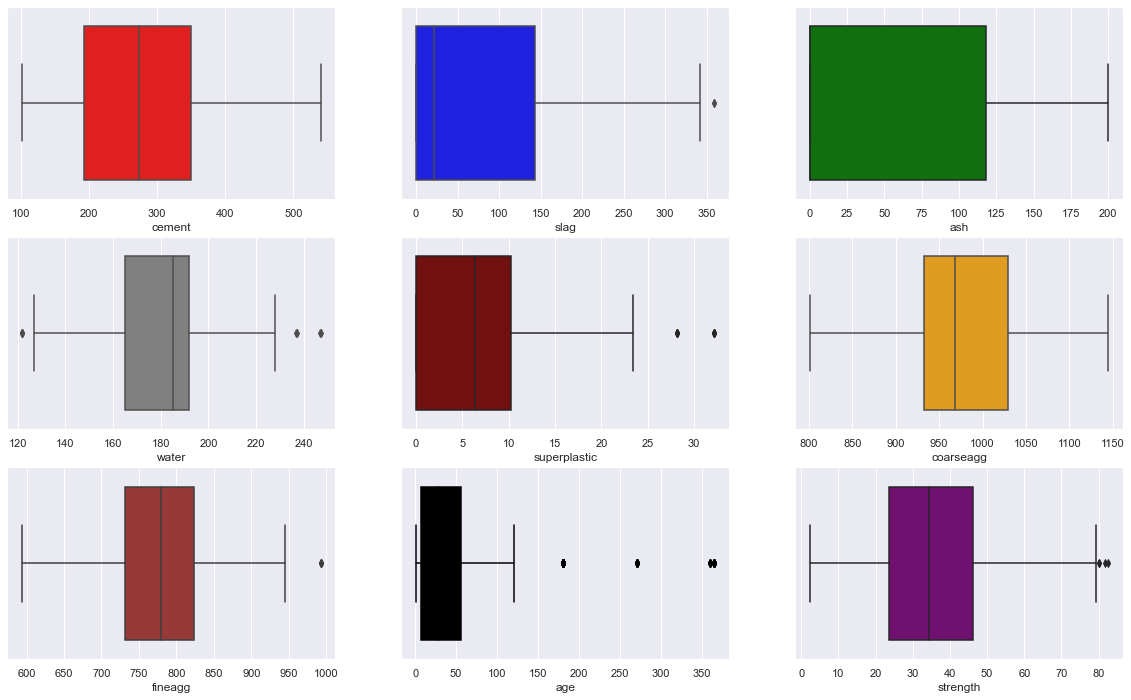

In [8]:
# Let's look at the distribution and IQRs for the attributes individually
plt.figure(figsize= (20,12))
for idx, col in enumerate(data_df.columns):
    plt.subplot(3, 3, idx+1)
    sns.boxplot(x=data_df[col], color=plot_colors[idx]);
    idx += 1

In [9]:
# Let's look at the skewness for variables
pd.DataFrame({'Skewness Value': [stats.skew(data_df[var]) for var in data_df.columns]}, index=data_df.columns).T

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
Skewness Value,0.508739,0.79955,0.536571,0.07452,0.905881,-0.040161,-0.252641,3.264415,0.41637


#### *Observations* :

1. **Cement (cement)**: Composition of cement in the concrete. This independent variable has fairly normal distribution. Most of the values lie between 190 to 270 kg/m3. There are no outliers reported. The mean and 50% quantile are closer indicating smaller skewness.


2. **Blast Furnace Slag (slag)**: This component of concrete is considerably skewed and has lot of zero values. There are negligible outliers. Most of the values are from 0-150 kg/m3. Large difference between mean and 50% quantile indicating larger skewness.


3. **Fly Ash (ash)**: This attribute has about half of the values as zeros. The distribution is quite skewed as the difference between mean and 50% quantile is large. Doesn't have significant outliers. 


4. **Water (water)**: Distribution looks fairly normal with mean and 50% quantile values being close. Three peaks in the distribution indicates three groups of majority values. No zero values found. Good number of outliers are observed.


5. **Superplasticizer (superplastic)**: There are lot of zero values reported with considerable skewness for this component of the concrete. Good amount of outliers to be handled.


6. **Coarse Aggregate (coarseagg)**: This attribute has fairly normal distribution with no outliers. Three peaks in the distribution indicates three groups of majority values. No zero values found.


7. **Fine Aggregate (fineagg)**: This component has fairly normal distribution with very few outliers. No zero values found. Similar distribution to Coarse Aggregate attribute.


8. **Age (age)**: This attribute has the highest skewness in the its distribution. Majority values lie between 0 to 90 days indicating smaller age. It has significant number of outliers that need to be treated.


9. **Concrete compressive strength (strength)**: This is the target (dependent) variable. Its distribution seems fairly normal with some outliers to be treated. The mean and 50% quantile are nearly equal. Most of the values appear to be from 20-50 kg/m3. 

### Multivariate Analysis <a class="anchor" id='1.2'></a>

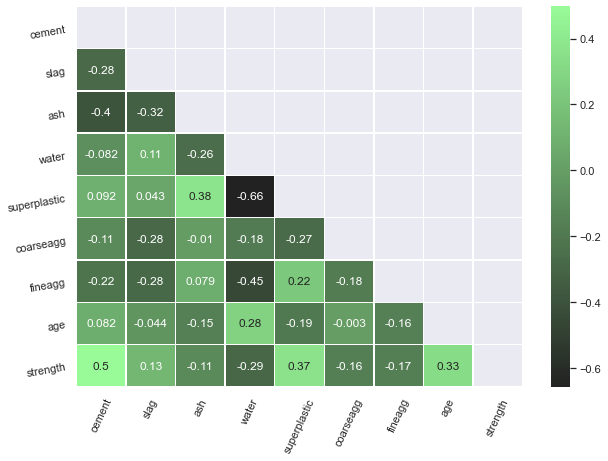

In [10]:
# Let's visualize heatmap for the co-relation between attributes.
corr_df = data_df.corr()

# Create a mask to hide upper triangle of repeated values
upper_tri_mask = np.zeros_like(corr_df, dtype=np.bool)
upper_tri_mask[np.triu_indices_from(upper_tri_mask)] = True

# Draw the heatmap
plt.figure(figsize=(10,7))
pal = sns.dark_palette("palegreen", as_cmap=True)
pop_hmap = sns.heatmap(corr_df, mask=upper_tri_mask, annot=True, cmap=pal, linewidths=.5)
pop_hmap.set_xticklabels(pop_hmap.get_xticklabels(), rotation=65)
pop_hmap.set_yticklabels(pop_hmap.get_yticklabels(), rotation=10)
plt.show()

#### *Observations*: 
1. High positive correlation between compressive strength (strength) and Cement (cement). This is intuitive as the compressive strength of the concrete increases with increase in amount of cement.

2. Age (age) and Super Plasticizer (supleplastic) also influence the compressive strength of the concrete with positive correlation.

3. There is a strong negative correlation between Super Plasticizer (superplastic) and Water (water). May be adding more water inherently decreases the super plasticizer.

4. Positive correlations are observed between Super Plasticizer (superplastic) and Fly Ash (ash), Fine Aggregate (fineagg).

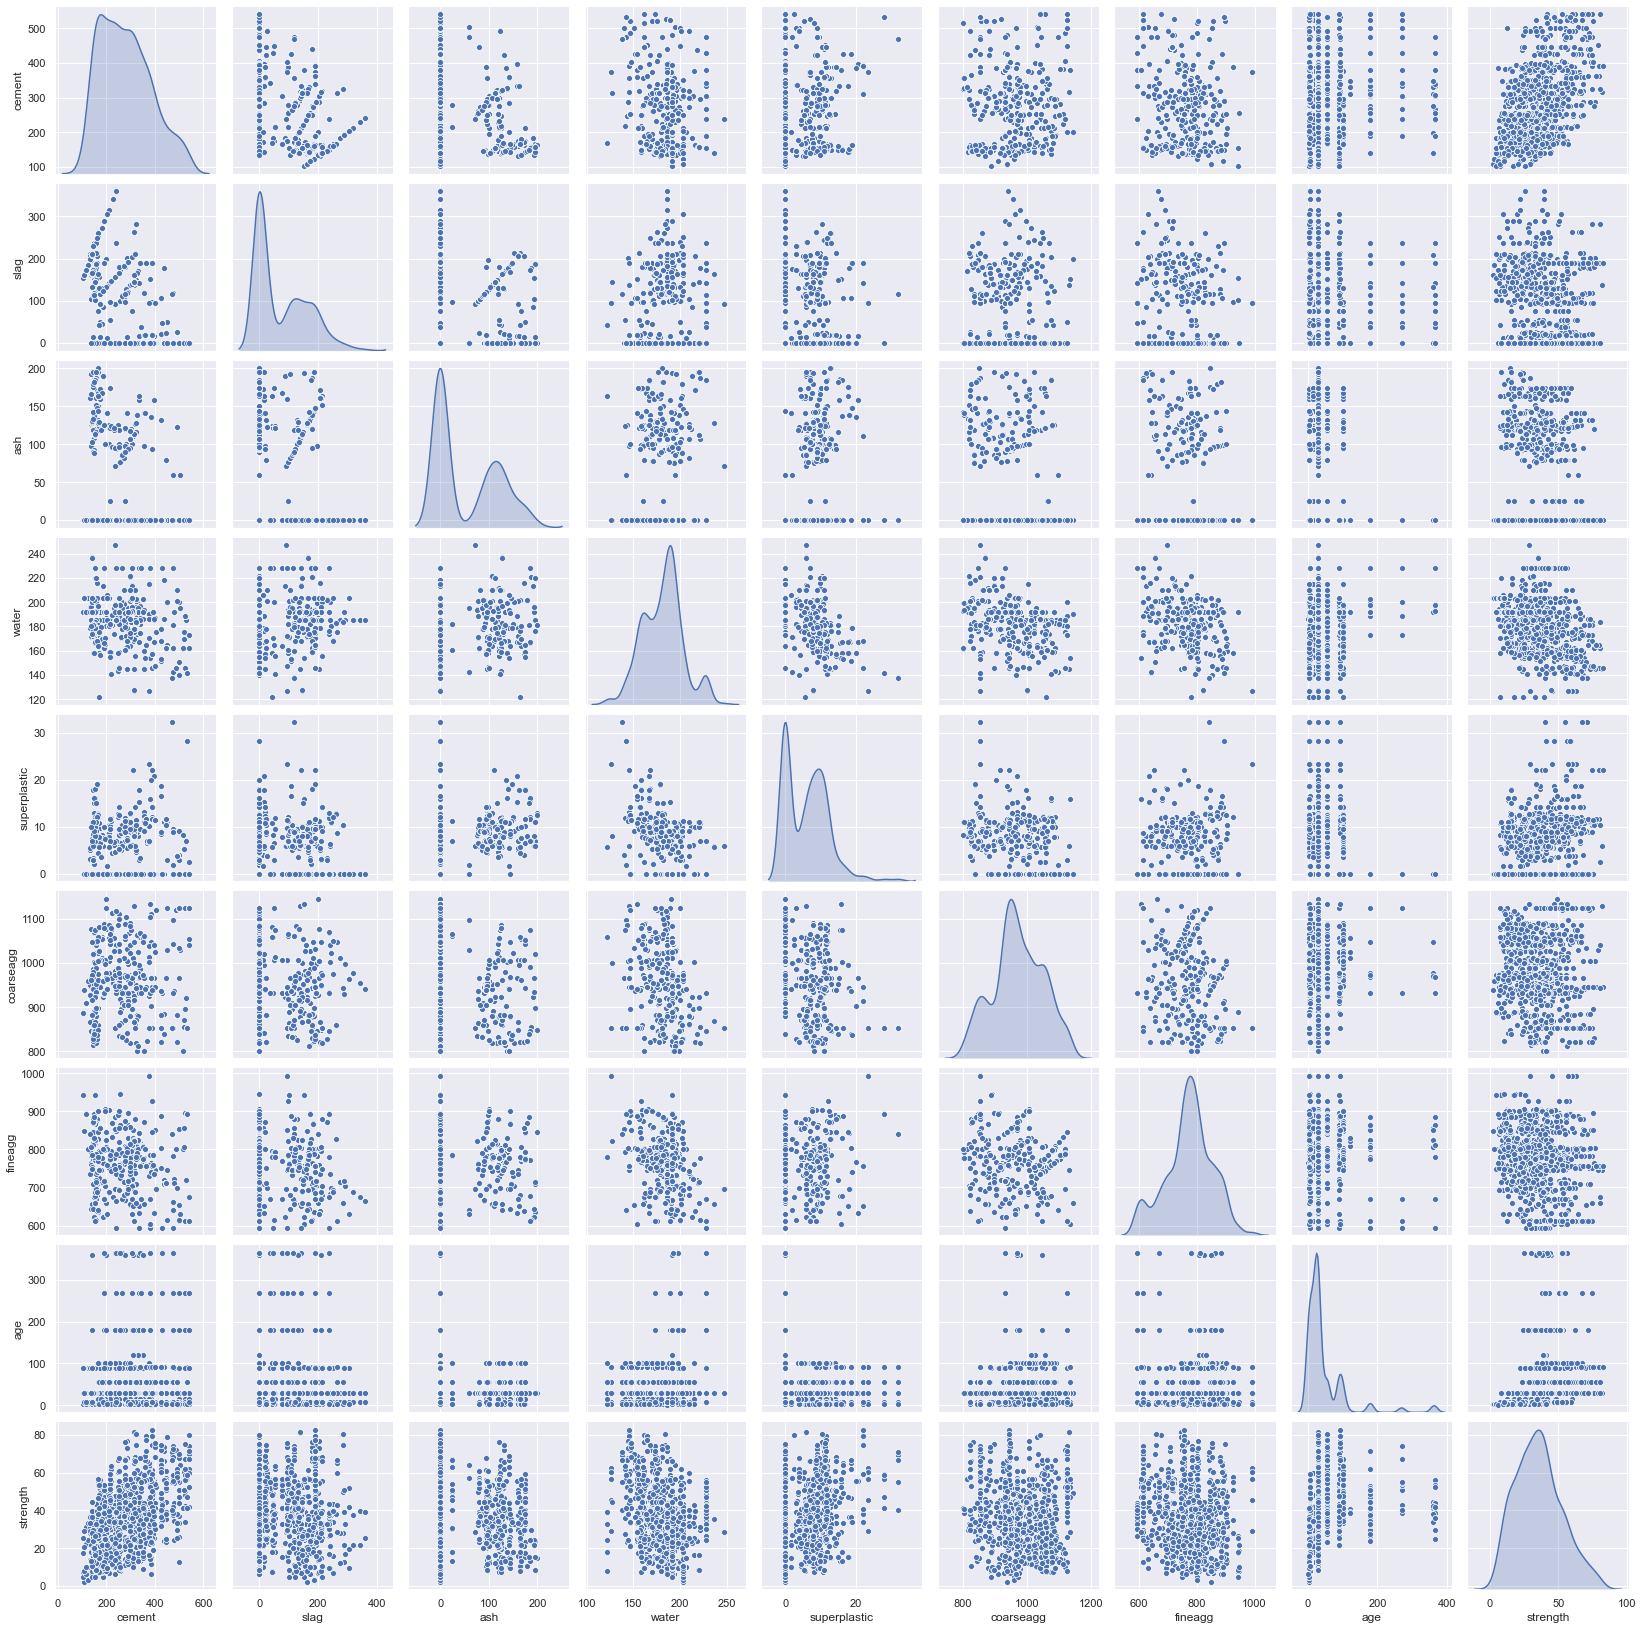

In [11]:
# Let's look at the pair wise relation ships between independent and dependent variables
sns.pairplot(data_df, diag_kind='kde');

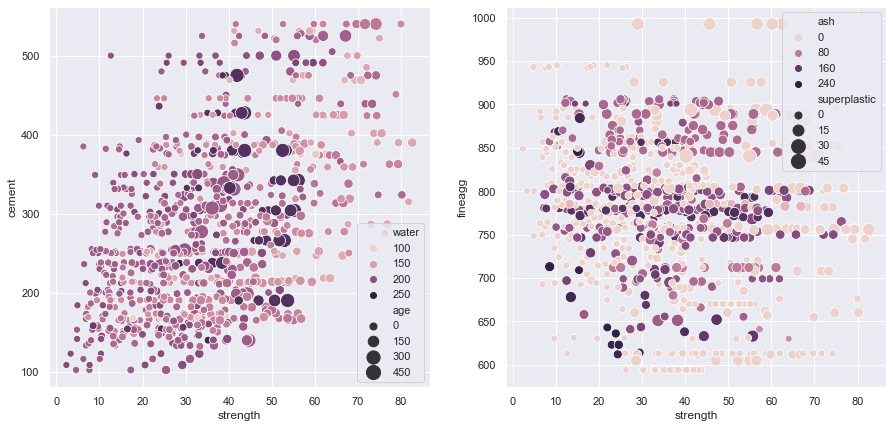

In [12]:
# Let's look at the impact on strength based on combination of other parameters.
plt.figure(figsize=(15,7))

# Let's look at the impact of cement, age and water on strength
plt.subplot(1, 2, 1)
sns.scatterplot(y="cement", x="strength", hue="water", size="age", data=data_df, sizes=(50, 200));

# Let's look at the impact of Fine aggregate, Super Plasticizer and Fly Ash on strength
plt.subplot(1, 2, 2)
sns.scatterplot(y="fineagg", x="strength", hue="ash", size="superplastic", data=data_df, sizes=(50, 200));

#### *Observations*:
1. From pair plots and above scatter plots, cement and strength seems to have near linear relationship. Compressive strength increases as the amount of cement increases.


2. Generally, strength seems to increase with age. However, there are certain instances where low age has high strength. May be some other attribute is contributing to the strength in those cases.


3. From the figure on left, it can be seen that:
    - Concrete with less age requires more cement for higher strength.
    - As the concrete gets older, more quantity of water is needed.
    - Also, concrete strength increases when good amount of water is used.
    
    
4. From the figure on the right, it can be observed that:
    - Strength increases with decrease in Fly Ash.
    - Also, strength increases with Super plasticizer.

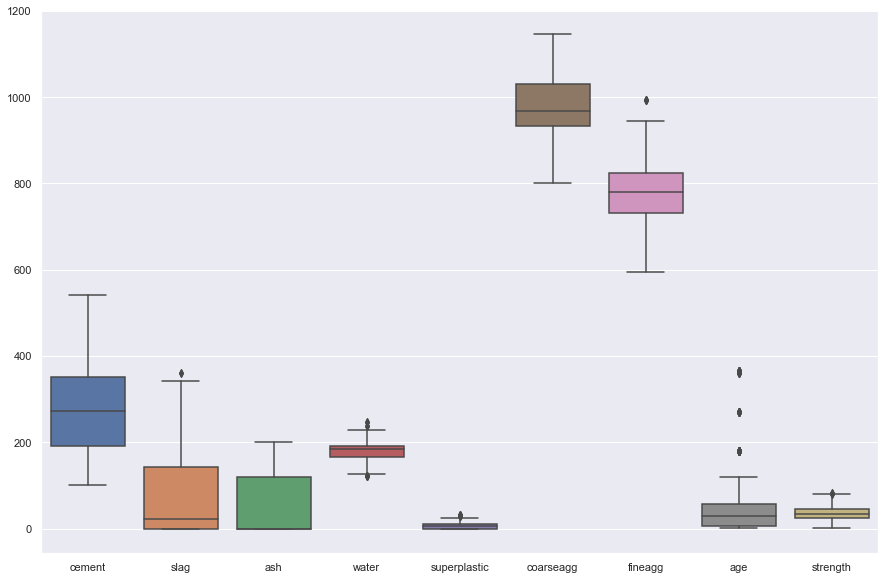

In [13]:
# Let's look at the IQRs using boxplots of all variables together.
plt.figure(figsize=(15,10))
sns.boxplot(data=data_df);

#### *Observations*:
1. Fine and coarse aggregate has disjoint ranges compared to other attribute values.
2. Slag, water, superplastic fineagg, age, and strength have smaller and closer outliers that should be treated. 


### Feature Engineering <a class="anchor" id='1.3'></a>

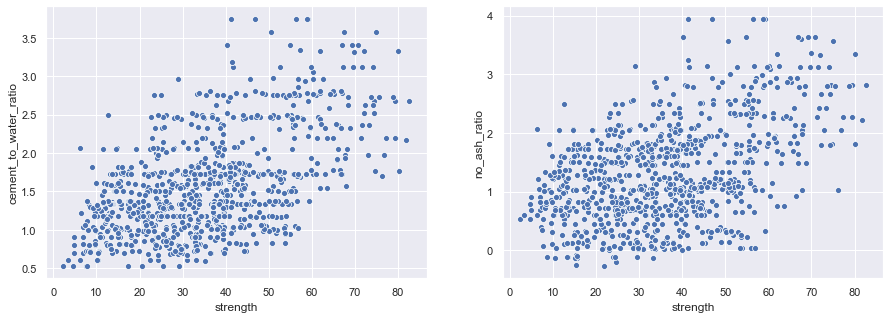

In [14]:
# Let's start by dropping the suplicates 
data_clean = data_df.drop_duplicates()

# Let's try to derive more attributes intuitively based on existing independent variable

# Let's calculate cement to water ratio
data_clean['cement_to_water_ratio'] = (data_clean['cement'] / data_clean['water'])

# Based on multi-variate analysis, Fly ash reduces strength and superplastic increases it. 
# Let's look at such component with superplastic and no fly ash, with respect to cement to water ratio.
data_clean['no_ash_ratio'] = (data_clean['superplastic'] + data_clean['cement'] - data_clean['ash']) / data_clean['water']

# Let's look at the relationship of the new features with target variable strength
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='strength', y='cement_to_water_ratio', data=data_clean);
plt.subplot(1, 2, 2)
sns.scatterplot(x='strength', y='no_ash_ratio', data=data_clean);

In [15]:
# Let's look at the correlation of the two new freatures we have derived
print("Correlation of 'Cement to water ratio' to strength: ", 
      round(data_clean.corr()['strength']['cement_to_water_ratio'], 3))

print()

print("Correlation of 'No ash ratio' to strength: ", 
      round(data_clean.corr()['strength']['no_ash_ratio'], 3))

Correlation of 'Cement to water ratio' to strength:  0.549

Correlation of 'No ash ratio' to strength:  0.468


The two new features have good positive correlation with strength. Let's see if they help in our predictive analysis ahead.

In [16]:
# Let's scale the features to adjust the data range and handle outliers
scale_cols = data_clean.columns.to_list()
scale_cols.remove('strength')
scaler = RobustScaler()
data_clean[scale_cols] = scaler.fit_transform(data_clean[scale_cols])
data_clean

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_to_water_ratio,no_ash_ratio
0,-0.781428,1.347368,0.000000,0.676806,-0.61,0.038384,-0.321757,0.000000,29.89,-0.995093,-0.408690
1,-0.607075,0.155789,1.050719,-1.041825,0.47,1.139394,0.165475,-0.285714,23.51,-0.504581,-0.720123
2,-0.094757,-0.140351,0.808960,0.064639,-0.06,-0.112121,0.829418,0.000000,29.22,-0.152989,-0.265469
3,0.006317,0.659649,0.000000,1.608365,-0.61,-0.363636,-1.123596,0.000000,45.85,-0.373328,0.018441
4,-0.696147,1.146667,0.000000,0.288973,0.30,0.802020,-0.850868,0.000000,18.29,-0.854923,-0.269825
...,...,...,...,...,...,...,...,...,...,...,...
1025,-0.821226,-0.140351,1.403212,-0.216730,0.39,-0.070707,0.255363,0.000000,13.29,-0.921833,-1.142115
1026,1.682249,-0.140351,0.000000,-1.669202,2.21,-1.170707,1.161389,-0.510204,41.30,3.023225,2.531601
1027,0.072015,0.673684,0.763314,-0.231939,0.28,-0.988889,-0.119510,0.000000,44.28,0.116784,-0.054738
1028,0.486418,0.126316,0.000000,1.608365,-0.61,-0.363636,-1.123596,4.938776,55.06,0.065476,0.319884


In [17]:
# Split independent variables from dependent variable
X = data_clean.drop('strength', axis=1) # Indpendent variables
Y = data_clean['strength'] # value to be pre-dicted 

print("Predictor feature shape: ", X.shape)
print("Target shape: ", Y.shape)
print("")

# Let's create train and test datasets using 80-20 split.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)

print("{0:0.2f}% data is in training set".format((len(x_train)/len(data_clean)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(data_clean)) * 100))

Predictor feature shape:  (1005, 10)
Target shape:  (1005,)

80.00% data is in training set
20.00% data is in test set


## Model Creation and Tuning <a class="anchor" id='2'></a>

This section focuses on creating different regressors with varying complexities and evaluating them using cross validation techniques. As a final check we fit the model on training set and evaluate on the test set. We pick the best performing model based on R2 score and tune it using hyper parameters to further improve the accuracy. 

For performance metrics we consider Train Accuracy, Test Accuracy, R2 score, Root Mean Squared Error (RMSE), Mean of KFold cross validation results (Cross Validation Mean) and the 95% confidence interval for KFold cross validation results.

### Creating And Evaluating Models <a class="anchor" id='2.1'></a>

In [18]:
# Utility method to evaluate model performance

def get_model_perf(model, scoring_method='r2'):
    ''' Method to get performance metrics of the model such as cross validation results, 
        train accuracy, test accuracy, r2 score and root mean sqaured error (RMSE)
            
        model - Untrained regressor instance.'''
    
    perf_dict = {}
    
    # Get cross validation results 
    
    # Note: The model is not fitted permanently during cross validation. 
    # and needs to be fitted to train split explicitly. There is no data leak encountered if 
    # cross validation is performed before fitting the model on training data.
    kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED)
    results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring_method)
    
    # Get cross valication mean and standard deviation
    cv_mean = results.mean() * 100.0
    std     = results.std() * 100.0
    
    # Get 95 % confidence interval
    low  = round(cv_mean - (1.96 * std / sqrt(len(results))), 3)
    high = round(cv_mean + (1.96 * std / sqrt(len(results))), 3)
    
    perf_dict['Cross Validation Mean']   = round(cv_mean, 3)
    perf_dict['95% Confidence Interval'] = "[{0}, {1}]".format(low, high)
    
    # Train the model explicitly
    model.fit(x_train, y_train)
    
    # predict using test data
    ypred = model.predict(x_test)
    
    # Get train and test accuracies   
    train_score = model.score(x_train, y_train)
    test_score  = model.score(x_test, y_test)
    perf_dict['Train Accuracy'] = round(train_score * 100.0, 3)
    perf_dict['Test Accuracy']  = round(test_score * 100.0, 3)
    
    # Get r2 score    
    perf_dict['R2 Score %'] = round(r2_score(y_test, ypred) * 100.0, 3)
    
    # Get root mean squred error
    perf_dict['Root Mean Squared Error'] = round(mean_squared_error(y_test, ypred, squared=False), 3)
    return perf_dict

#### Linear Regression with Regularization

In [19]:
# Let's create Linear Regression models with Ridge and Lasso regilarization
lr_models = [LinearRegression(), Ridge(random_state=SEED), Lasso(random_state=SEED)]
lr_model_names = [type(model).__name__ for model in lr_models]
lr_model_perfs = [get_model_perf(model) for model in lr_models]
pd.DataFrame(lr_model_perfs, index=lr_model_names).T

,LinearRegression,Ridge,Lasso
Cross Validation Mean,57.438,57.59,51.088
95% Confidence Interval,"[52.306, 62.57]","[52.57, 62.611]","[47.352, 54.824]"
Train Accuracy,61.625,61.549,53.955
Test Accuracy,54.884,55.561,51.544
R2 Score %,54.884,55.561,51.544
Root Mean Squared Error,11.069,10.985,11.471


In [20]:
# Let's look at the feature importances in terms of parameter coefficients
lr_coeff_dict = {}
for name, model in zip(lr_model_names, lr_models):
    lr_coeff_dict[name] = [model.coef_[i] for i in range(len(x_train.columns))]

pd.DataFrame(lr_coeff_dict, index=x_train.columns)

,LinearRegression,Ridge,Lasso
cement,25.951564,19.989189,0.000000
slag,15.810356,14.876468,3.690784
ash,13.401556,9.457492,0.000000
water,-5.088123,-3.857365,-1.970559
superplastic,3.245601,3.363204,3.435672
coarseagg,2.437419,2.077667,-0.000000
fineagg,3.007160,2.431724,-0.812818
age,5.563653,5.491453,4.257181
cement_to_water_ratio,-7.476443,0.770306,8.659695
no_ash_ratio,3.512116,-1.988907,0.000000


#### *Observations* : 
1. In terms of R2 Score, Ridge performs better than Linear Regression and Lasso. Ridge also has better confidence interval.
2. Cement, slag, ash, age, and 'no_ash_ratio' are the top important features for Linear Regression. It did not give superplastic and cement_to_water_ratio as much importance.
3. Ridge Regression found cement, slag, ash and age important. It also failed to give higher importance to superplastic and cement_to_water ratio.
4. Lasso found slag, superplastic, age and cement_to_water_ratio important. However, its r2 score is lowest.
5. None of these models have yielded R2 score in the expected range of 80% to 95%.

#### Regression with Polynomial Features

In [21]:
# Let's try higher order features for linear regression models created above.
lr_poly_models = [Pipeline([('poly_feat', PolynomialFeatures(degree=2)), ('reg', LinearRegression())]),
                    Pipeline([('poly_feat', PolynomialFeatures(degree=2)), ('reg', Ridge(random_state=SEED))]),
                    Pipeline([('poly_feat', PolynomialFeatures(degree=2)), ('reg', Lasso(random_state=SEED))])]

lr_poly_model_names = ['Polynomial_' + type(model.named_steps['reg']).__name__ for model in lr_poly_models]
lr_poly_model_perfs = [get_model_perf(model) for model in lr_poly_models]
pd.DataFrame(lr_poly_model_perfs, index=lr_poly_model_names).T

,Polynomial_LinearRegression,Polynomial_Ridge,Polynomial_Lasso
Cross Validation Mean,76.457,76.723,64.148
95% Confidence Interval,"[73.165, 79.749]","[73.48, 79.966]","[61.063, 67.234]"
Train Accuracy,76.538,81.525,66.1
Test Accuracy,67.376,74.676,64.018
R2 Score %,67.376,74.676,64.018
Root Mean Squared Error,9.412,8.293,9.885


In [22]:
# Let's look at the feature importances in terms of parameter coefficients
lr_poly_coeff_dict = {}
for name, model in zip(lr_poly_model_names, lr_poly_models):
    lr_poly_coeff_dict[name] = [model.named_steps['reg'].coef_[i] for i in range(len(x_train.columns))]

pd.DataFrame(lr_poly_coeff_dict, index=x_train.columns)

,Polynomial_LinearRegression,Polynomial_Ridge,Polynomial_Lasso
cement,-1.013054e+14,0.000000,0.000000
slag,1.589037e+01,6.456263,0.000000
ash,1.650657e+01,11.457482,3.980039
water,2.091643e+01,3.192718,0.000000
superplastic,2.014069e+01,3.290628,-1.581776
coarseagg,1.809782e+01,8.197661,2.896497
fineagg,-1.114592e+01,-2.900139,-0.000000
age,1.842729e+01,-0.644653,-0.767412
cement_to_water_ratio,1.332021e+01,12.203030,10.881556
no_ash_ratio,5.616103e+00,5.708213,8.857959


#### *Observations* : 
1. Over all performance of the models have increased with polynomial features. Especially, the R2 score.
2. With polynomial features, Ridge performed better than Lasso and close to linear regression.
3. Linear Regression considered the importance of superplastic and cement_to_water_ratio this time.
4. All models with polynomial features found cement_to_water ratio significantly important.
5. Still, none of these models have yielded R2 score in the target range of 80% to 95%.

#### Now we consider Decision Trees and ensemble models such as Random Forrest, Ada and Gradient Boost Regressors

In [23]:
# Create relevant models

# For tree based models, inorder to avoid overfitting we will provide a random value for max_depth.
tree_ensemble_models = [
    DecisionTreeRegressor(max_depth=10, random_state=SEED),
    AdaBoostRegressor(random_state=SEED),
    GradientBoostingRegressor(random_state=SEED),
    RandomForestRegressor(max_depth=10, random_state=SEED)
]

# Names of the models for displaying reults.
tree_ensemble_model_names = [type(model).__name__ for model in tree_ensemble_models]

# Get model performance
tree_ensemble_model_perfs = [get_model_perf(model) for model in tree_ensemble_models]

# Display results
pd.DataFrame(tree_ensemble_model_perfs, index=tree_ensemble_model_names).T

,DecisionTreeRegressor,AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
Cross Validation Mean,85.064,78.599,90.755,90.839
95% Confidence Interval,"[82.146, 87.981]","[76.766, 80.431]","[89.479, 92.03]","[88.864, 92.814]"
Train Accuracy,98.288,82.476,94.902,98.062
Test Accuracy,86.543,80.561,90.652,91.916
R2 Score %,86.543,80.561,90.652,91.916
Root Mean Squared Error,6.045,7.265,5.038,4.685


In [24]:
# Let's look at the feature importances of these models
feat_imp_dict = {}
for model, name in zip(tree_ensemble_models, tree_ensemble_model_names):
    feat_imp_dict[name] = list(model.feature_importances_)

pd.DataFrame(feat_imp_dict, index=x_train.columns)

,DecisionTreeRegressor,AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
cement,0.003266,0.044138,0.028198,0.031944
slag,0.114301,0.103974,0.092122,0.077993
ash,0.005370,0.000000,0.002051,0.009600
water,0.051002,0.131859,0.061003,0.046378
superplastic,0.024623,0.028894,0.042260,0.047754
coarseagg,0.019397,0.032044,0.016011,0.022248
fineagg,0.016449,0.034320,0.037107,0.036717
age,0.330257,0.245555,0.386854,0.358455
cement_to_water_ratio,0.406460,0.345418,0.314810,0.340014
no_ash_ratio,0.028874,0.033797,0.019583,0.028897


#### *Observations* : 
1. Gradient Boost and Random Forrest are the top two regressors with respect to R2 score and root mean squared error.
2. These two regressors have the R2 score in the expected range of 80 to 95% .
3. Age, superplastic and cement_to_water ratio has been found fairly important by all the regressors above.

#### Performance Summary of Models

In [25]:
# Let's look at the performance summary of all the regressors evaluted so far
all_model_perfs = (lr_model_perfs + lr_poly_model_perfs + tree_ensemble_model_perfs)
all_model_names = (lr_model_names + lr_poly_model_names + tree_ensemble_model_names)
pd.DataFrame(all_model_perfs, index=all_model_names)

,Cross Validation Mean,95% Confidence Interval,Train Accuracy,Test Accuracy,R2 Score %,Root Mean Squared Error
LinearRegression,57.438,"[52.306, 62.57]",61.625,54.884,54.884,11.069
Ridge,57.590,"[52.57, 62.611]",61.549,55.561,55.561,10.985
Lasso,51.088,"[47.352, 54.824]",53.955,51.544,51.544,11.471
Polynomial_LinearRegression,76.457,"[73.165, 79.749]",76.538,67.376,67.376,9.412
Polynomial_Ridge,76.723,"[73.48, 79.966]",81.525,74.676,74.676,8.293
Polynomial_Lasso,64.148,"[61.063, 67.234]",66.100,64.018,64.018,9.885
DecisionTreeRegressor,85.064,"[82.146, 87.981]",98.288,86.543,86.543,6.045
AdaBoostRegressor,78.599,"[76.766, 80.431]",82.476,80.561,80.561,7.265
GradientBoostingRegressor,90.755,"[89.479, 92.03]",94.902,90.652,90.652,5.038
RandomForestRegressor,90.839,"[88.864, 92.814]",98.062,91.916,91.916,4.685


#### *Observations* : 
1. Basic Linear Regression did not yield the expected performance in terms of R2 score.
2. Regularizing linear regression (Ridge) improved performance to some extent, but not enough to get us to the expected R2 score between 80% to 95%.
3. Adding polynomial features improved the R2 score significantly. Yet, little shy of the expected range (80% - 95%).
4. Finally, tree based and ensemble models performed way better and got us to the expected performance range.

### Hyperparameter Tuning <a class="anchor" id='2.2'></a>

Based on performance summary above, we select RandomForrestRegressor and GradientBoostingRegressor for further improving the performance, using hyper parameter tuning. 

#### Hyper parameter tuning for RandomForrestRegressor using Grid Search Cross Validation

In [26]:
# define parameters to be tuned.
# Note: I have considered a subset of pameters as grid search takes a long time to find the best parameters.
# With infinite time, more parameters and their values can be considered to squeeze the most performance 
# out of the model in consideration.
rf_gs_params_dict = {
    'max_depth'    : [15, 20, None],
    'n_estimators' : [100, 150, 200, 250, 300],
    'max_features' : [1, 2, 4, 6],
    'criterion'    : ["mse", "mae"],
    'bootstrap'    : [True, False]
}

# Clone the RandomForrestRegressor we have trained before on training data
rf_gs_model_trained = clone(tree_ensemble_models[3])

# Create instance of grid search cross validation.
# Note: setting n_jobs to -1 consumes all available CPU during the call to fit() and speeds up the search.
gscv_for_random_forrest = GridSearchCV(rf_gs_model_trained, param_grid=rf_gs_params_dict, n_jobs=-1)  

# Get start time
start = time()

# Find best hpyer parameter values based on training data
gscv_for_random_forrest.fit(x_train, y_train);

# Get end time
end = time()
print("Time taken for grid search: {0} mins".format(round((end-start)/60.0, 3)))

# View the best hyper parameter values found
print("Hyper parameters for RandomForrestRegressor (using grid search) with best score: ", 
      round(gscv_for_random_forrest.best_score_, 3))

pd.DataFrame(gscv_for_random_forrest.best_params_, index=['Best Value']).T

Time taken for grid search: 5.968 mins
Hyper parameters for RandomForrestRegressor (using grid search) with best score:  0.907


,Best Value
bootstrap,False
criterion,mae
max_depth,15
max_features,4
n_estimators,200


In [27]:
# Let's create a Random Forest Regressor model based on tuned hyper parameters
rf_gs_model_tuned = RandomForestRegressor(random_state=SEED, **gscv_for_random_forrest.best_params_)

# Evaluate the performance using KFold cross validation
rf_gs_model_tuned_perf = get_model_perf(rf_gs_model_tuned)
pd.DataFrame(rf_gs_model_tuned_perf, index=['Random Forest Regressor (Grid Search Tuned)']).T

,Random Forest Regressor (Grid Search Tuned)
Cross Validation Mean,92.109
95% Confidence Interval,"[89.931, 94.287]"
Train Accuracy,99.821
Test Accuracy,92.232
R2 Score %,92.232
Root Mean Squared Error,4.593


#### Hyper parameter tuning for RandomForrestRegressor using Randomized Search Cross Validation

In [28]:
# Parameters selected for hyper parameters for tuning.
rf_rs_params_dict = {
    'max_depth'        : [15, 20, None],
    'n_estimators'     : sp_randint(100, 151),
    'max_features'     : sp_randint(2, 11),
    'criterion'        : ["mse", "mae"],
    'bootstrap'        : [True, False]
}

# Clone the RandomForrestRegressor we have trained before on training data
rf_rs_model_trained = clone(tree_ensemble_models[3])

# Create instance of randomized search cross validation
rscv_for_random_forrest = RandomizedSearchCV(rf_rs_model_trained, param_distributions=rf_rs_params_dict, 
                                             n_iter=10, n_jobs=-1)

# Record start time
start = time()

# Find best hpyer parameter values
rscv_for_random_forrest.fit(x_train, y_train);

# Record end time
end = time()
print("Time taken for random search: {0} mins".format(round((end-start)/60.0, 3)))

# View the best hyper parameter values found
print("Hyper parameters for RandomForrestRegressor (using random search), with best score: ", 
      round(rscv_for_random_forrest.best_score_, 3))

pd.DataFrame(rscv_for_random_forrest.best_params_, index=['Best Value']).T

Time taken for random search: 0.248 mins
Hyper parameters for RandomForrestRegressor (using random search), with best score:  0.904


,Best Value
bootstrap,False
criterion,mae
max_depth,20
max_features,3
n_estimators,118


In [29]:
# Let's create a Random Forest Regressor model based on tuned hyper parameters
rf_rs_model_tuned = RandomForestRegressor(random_state=SEED, **rscv_for_random_forrest.best_params_)

# Evaluate the performance use KFold cross validation
rf_rs_model_tuned_perf = get_model_perf(rf_rs_model_tuned)
pd.DataFrame(rf_rs_model_tuned_perf, index=['Random Forest Regressor (Random Search Tuned)']).T

,Random Forest Regressor (Random Search Tuned)
Cross Validation Mean,91.942
95% Confidence Interval,"[89.812, 94.072]"
Train Accuracy,99.847
Test Accuracy,91.916
R2 Score %,91.916
Root Mean Squared Error,4.685


#### Hyper parameter tuning for GradientBoostingRegressor using Grid Search

In [30]:
# Hyper parameters considered  
# Note: I have considered a subset of pameters as grid search takes a long time to find the best parameters.
# With infinite time, more parameters and their values can be considered to squeeze the most performance 
# out of the model in consideration.
gb_gs_params_dict = {
    'loss'          : ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'criterion'     : ['friedman_mse', 'mse', 'mae'],
    'max_depth'     : [10, 14, 20, None],
    'n_estimators'  : [100, 150, 200, 250]
}

# Clone the GradientBoostingRegressor we have trained before on training data
gb_gs_model_trained = clone(tree_ensemble_models[2])

# Create instance of randomized search cross validation
gscv_for_gradient_boost = GridSearchCV(gb_gs_model_trained, param_grid=gb_gs_params_dict, n_jobs=-1)

# Record start time
start = time()

# Find best hpyer parameter values
gscv_for_gradient_boost.fit(x_train, y_train)

# Record end time
end = time()
print("Time taken for grid search: {0} mins".format(round((end-start)/60.0, 3)))

# View the best hyper parameter values found
print("Hyper parameters for GradientBoostingRegressor (using grid search) with best score: ", 
      round(gscv_for_gradient_boost.best_score_,3))

pd.DataFrame(gscv_for_gradient_boost.best_params_, index=['Best Value']).T

Time taken for grid search: 83.984 mins
Hyper parameters for GradientBoostingRegressor (using grid search) with best score:  0.914


,Best Value
criterion,mse
learning_rate,0.05
loss,lad
max_depth,10
n_estimators,250


In [31]:
# Let's create a Gradient Boosting Regressor model based on tuned hyper parameters
gb_gs_model_tuned = GradientBoostingRegressor(random_state=SEED, **gscv_for_gradient_boost.best_params_)

# Evaluate the performance use KFold cross validation
gb_gs_model_tuned_perf = get_model_perf(gb_gs_model_tuned)
pd.DataFrame(gb_gs_model_tuned_perf, index=['Gradient Boosting Regressor (Grid Search Tuned)']).T

,Gradient Boosting Regressor (Grid Search Tuned)
Cross Validation Mean,92.113
95% Confidence Interval,"[89.916, 94.309]"
Train Accuracy,99.29
Test Accuracy,92.301
R2 Score %,92.301
Root Mean Squared Error,4.573


#### Hyper parameter tuning for GradientBoostingRegressor using Randomized Search

In [32]:
# Hyper parameters to be considered
gb_rs_params_dict = {
    'loss'          : ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate' : np.random.random(20),
    'criterion'     : ['friedman_mse', 'mse', 'mae'],
    'max_depth'     : [10, 14, 20, None]
}

# Clone the GradientBoostingRegressor we have trained before on training data
gb_rs_model_trained = clone(tree_ensemble_models[2])

# Create instance of randomized search cross validation
rscv_for_gradient_boost = RandomizedSearchCV(gb_rs_model_trained, param_distributions=gb_rs_params_dict, 
                                             n_iter=7, n_jobs=-1)

# Record start time
start = time()

# Find best hpyer parameter values
rscv_for_gradient_boost.fit(x_train, y_train)

# Record end time
end = time()
print("Time taken for random search: {0} mins".format(round((end-start)/60.0, 3)))

# View the best hyper parameter values found
print("Hyper parameters for GradientBoostingRegressor (using random search) with best score: ", 
      rscv_for_gradient_boost.best_score_ )

pd.DataFrame(rscv_for_gradient_boost.best_params_, index=['Best Value']).T

Time taken for random search: 0.464 mins
Hyper parameters for GradientBoostingRegressor (using random search) with best score:  0.9056430617566787


,Best Value
max_depth,10
loss,lad
learning_rate,0.158784
criterion,mse


In [33]:
# Let's create a Gradient Boosting Regressor model based on tuned hyper parameters
gb_rs_model_tuned = GradientBoostingRegressor(random_state=SEED, **rscv_for_gradient_boost.best_params_)

# Evaluate the performance use KFold cross validation
gb_rs_model_tuned_perf = get_model_perf(gb_rs_model_tuned)
pd.DataFrame(gb_rs_model_tuned_perf, index=['Gradient Boosting Regressor Tuned']).T

,Gradient Boosting Regressor Tuned
Cross Validation Mean,91.898
95% Confidence Interval,"[89.813, 93.983]"
Train Accuracy,99.068
Test Accuracy,90.981
R2 Score %,90.981
Root Mean Squared Error,4.949


#### Performance Summary of Random Forrest and Gradient Boosting  Regressors before and after Hyper parameter tuning

In [34]:
# Let's get all the relevant model performance data 
rf_model_perf, gb_model_perf = tree_ensemble_model_perfs[3],tree_ensemble_model_perfs[2]

model_names = [
    'Random Forrest Regressor (Before Tuning)',
    'Random Forrest Regressor (Grid Search Tuned)', 
    'Random Forrest Regressor (Randomized Search Tuned)', 
    'Gradient Boost Regressor (Before Tuning)', 
    'Gradient Boost Regressor (Grid Search Tuned)',
    'Gradient Boost Regressor (Randomized Search Tuned)'
]

# Display performance results before and after hyper parameter tuning
pd.DataFrame([
    rf_model_perf, 
    rf_gs_model_tuned_perf,
    rf_rs_model_tuned_perf, 
    gb_model_perf, 
    gb_gs_model_tuned_perf,
    gb_rs_model_tuned_perf
], index=model_names)

,Cross Validation Mean,95% Confidence Interval,Train Accuracy,Test Accuracy,R2 Score %,Root Mean Squared Error
Random Forrest Regressor (Before Tuning),90.839,"[88.864, 92.814]",98.062,91.916,91.916,4.685
Random Forrest Regressor (Grid Search Tuned),92.109,"[89.931, 94.287]",99.821,92.232,92.232,4.593
Random Forrest Regressor (Randomized Search Tuned),91.942,"[89.812, 94.072]",99.847,91.916,91.916,4.685
Gradient Boost Regressor (Before Tuning),90.755,"[89.479, 92.03]",94.902,90.652,90.652,5.038
Gradient Boost Regressor (Grid Search Tuned),92.113,"[89.916, 94.309]",99.290,92.301,92.301,4.573
Gradient Boost Regressor (Randomized Search Tuned),91.898,"[89.813, 93.983]",99.068,90.981,90.981,4.949


#### *Observations*:
1. Hyper parameter tuning helped squeeze additional performance out of models in terms of Cross Validation Mean and R2 score %.
2. Based on above data, hyper parameters found using grid search yielded best performance for both the regressors.
3. Grid search took more time than randomized search to find the best parameters.
4. Randomized search doesn't always guarantee the best hyper parameters. However, it can get relatively good performance improvement in short amount of time. Also, it considers parameter values that grid search may not consider as the values  may not be present in the specified grid.
5. The R2 score of both regressors is improved after hyper parameter tuning and is in the expected range of 80% - 95%.

In [35]:
# Let's look at the feature importances of these models
model_names = [
    'Random Forrest Regressor (Grid Search Tuned)', 
    'Random Forrest Regressor (Randomized Search Tuned)',  
    'Gradient Boost Regressor (Grid Search Tuned)',
    'Gradient Boost Regressor (Randomized Search Tuned)'
]

models = [ 
    rf_gs_model_tuned,
    rf_rs_model_tuned, 
    gb_gs_model_tuned,
    gb_rs_model_tuned
]

feature_importance_dict = {}
for model, name in zip(models, model_names):
    feature_importance_dict[name] = list(model.feature_importances_)

pd.DataFrame(feature_importance_dict, index=x_train.columns)

,Random Forrest Regressor (Grid Search Tuned),Random Forrest Regressor (Randomized Search Tuned),Gradient Boost Regressor (Grid Search Tuned),Gradient Boost Regressor (Randomized Search Tuned)
cement,0.090251,0.094911,0.089080,0.092229
slag,0.078745,0.069431,0.087683,0.089231
ash,0.026750,0.030660,0.036358,0.052152
water,0.069087,0.071050,0.080656,0.075405
superplastic,0.051030,0.048662,0.071489,0.067600
coarseagg,0.053377,0.056305,0.117657,0.120511
fineagg,0.059279,0.061705,0.098831,0.101897
age,0.318857,0.331617,0.206877,0.201159
cement_to_water_ratio,0.156842,0.135022,0.128462,0.111432
no_ash_ratio,0.095783,0.100638,0.082907,0.088383


#### *Observations* :
1. Age, cement_to_water_ratio, cement, no_ash_ratio are among the top important features that above high performing regressors have identified.
2. Feature engineered attributes: cement_to_water_ratio and no_as_ratio have helped in improving the prediction performance of these models.
3. superplastic although identified significant earlier did not turn out to be as important feature. May be because of lot of zero values in the dataset.
4. Fineagg and coarseagg have been identified relatively important by gradient boosting regressor. 

## Conclusion <a class="anchor" id='3'></a>
1. Predicting compressive concrete strength of the concrete has been a challenging regression problem. 
2. Solution to this problem was started with understanding the data, by performing univariate and multi-variate analysis.
3. Based on the understanding, data processing was performed, such as cleaning and scaling the data.
4. Feature engineering was performed and couple of new features were derived that had good correlation with target variable.
5. Various regressors were used and their performance was evaluated based on KFold cross validation and a final performance check was performed using train and test split.
6. Top two performing regressors were selected for further performance improvement using hyper parameter tuning.
7. Hyper parameter tuning was performed using grid search and randomized search to select best parameters for those top two regressors.
8. R2 score, in the expected range of 80%-95% has been achieved!